# Create multliayer Food groups 
It is a copy of Multilayer food_groups.ipynb but that I am going to mess-up to tranform into a code that I can apply to make trajectories of a country across the years

In [1]:
import pandas as pd
import numpy as np
import time
import networkx as nx
import geopandas as gpd # pip installed
import matplotlib.pyplot as plt 
import pickle
import plotly.express as px
from tqdm import tqdm

In [2]:
# FUNCTION DEFINITION:
def Food_group_sum (data, f_group):
    filt_data= data.loc[data.Food_group == f_group,:]
    data_grouped= filt_data.groupby(['Food_group','unit','origin_country','destin_country','year'])
    filt_data.loc[:,'value']= data_grouped.value.transform('sum')

    filt_data.loc[:,'item']= f_group
    return(filt_data)

def FoodEx_aggregation (data):
    food_groups = data.Food_group.unique() 

    # Iterate per food group
    data_fg= Food_group_sum(data,food_groups[0])
    
    for f in tqdm(food_groups[1:]): 
        data_fg= pd.concat([data_fg, Food_group_sum(data,f)], ignore_index=True)

    data_out = data_fg.drop_duplicates()
    return data_out.drop(columns='item')

def Node_strength(data, direction, group_class, weight = True):
    """ Calculate the node relevance in each layer of the multilayer network. 
    In a weighted directed network the country strenght is the sum of the magnitude exported by that country in that layer.

    Parameters:
    - data (pd.DataFrame): Input DataFrame containing trade data for a single year. The dataframe must contain 
    the columns: 'item', 'unit', 'origin_country_ISO', and 'value'.

    Returns:
    pd.DataFrame: DataFrame with country strength for each combination of 'item' and 'unit', sorted from highest to lowest. 
    Columns include 'item', 'unit', 'origin_country_ISO', and the calculated 'value' for node strength.

    Example:
    >>> df_result = Node_strength_w(input_data)
    """

    if direction == 'out':
        country_group = 'origin_country_ISO'
    else: 
        country_group = 'destin_country_ISO'

    if (weight==True):
        str_i_l = data.groupby([group_class,'unit']).apply(lambda group: group.loc[:,[country_group,'value']].
                                                        pivot_table(index=country_group, aggfunc='sum').
                                                        sort_values(by = 'value',ascending=False))
        strength_i_l= str_i_l.reset_index(level=[group_class,'unit',country_group]).rename(columns={'value':'str_i_l'})

    else:
        data['dum_weight']= 1
        str_i_l = data.groupby([group_class,'unit']).apply(lambda group: group.loc[:,[country_group,'value']].
                                                        pivot_table(index=country_group, aggfunc=lambda x: len(x)).
                                                        sort_values(by = 'value',ascending=False))
        strength_i_l= str_i_l.reset_index(level=[group_class,'unit',country_group]).rename(columns={'value':'str_i_l'})

    return strength_i_l

def Participation_coeff (data, overlap, direction, group_class, weight):

    if (weight == True):
        w_f = '_w'
        flag_overlap = 'overl'
    else:
        w_f = ''
        flag_overlap = 'deg'

    if direction == 'out':
        country_group = 'origin_country_ISO'
    else: 
        country_group = 'destin_country_ISO'
    #Define elements for part_coeff
    L = len(data[group_class].unique()) # Is this correct???
    
    s_i_l = Node_strength(data, direction, group_class,weight)

    # Prepare data
    #data_for_Pc = pd.merge(s_i_l, o_i, left_on= 'origin_country_ISO',right_index=True, how='left')
    data_for_Pc = pd.merge(s_i_l, overlap.loc[:,['country',direction+'_'+flag_overlap]], left_on= country_group,right_on='country', how='left')

    # Contibution of each layer to total exports:
    data_for_Pc['sum_layers'] = (data_for_Pc['str_i_l']/data_for_Pc[direction+'_'+flag_overlap])**2
    
    sum_layers= data_for_Pc.groupby([country_group]).apply(lambda group: group.sum_layers.sum())

    particip_coeff = (pd.DataFrame((L/(L-1))*(1- sum_layers),columns=['pc'+w_f+'_'+direction]).
                      sort_values(by='pc'+w_f+'_'+direction,ascending=False))
    return particip_coeff 

def Agregated_network (edge_data,node_info, group_class):
    
    # General network 
    pos_dict = node_info.loc[:,['ISO','pos','name']].set_index('ISO').to_dict(orient='index')
    pos_dict

    edge_dict =dict(zip(zip(edge_data['origin_country_ISO'], edge_data['destin_country_ISO'], edge_data[group_class]), edge_data['value']))
    edge_dict

    # Create network
    G=nx.MultiDiGraph()

    G.add_nodes_from(pos_dict)
    nx.set_node_attributes(G,pos_dict)

    G.add_edges_from(edge_dict.keys())
    nx.set_edge_attributes(G, edge_dict, 'weight')
    nx.set_edge_attributes(G, edge_dict.keys(), '<attribute_name>')
    return G
        
def Make_dict_years (data_in, country_metadata, direction, group_class, year_check,unit_flag):
    """ 
    Iterate everything to filter data per year, get network and network stats. 
    The output should be a the dataframe with the value of overlap and zscore for each country the year being explored. 

    This will be saved in a dictionary. 
    """
    if unit_flag== 'dollars':
        unit_val = '1000 US$'
    else:
        unit_val = unit_flag
    
    #Load data 
    data_filt = data_in.loc[(data_in.unit ==unit_val) & (data_in.year == year_check) & (data_in.value > 0) ,:].copy()
    # Create agregated multilayer network 
    G = Agregated_network(data_filt, country_metadata, group_class = group_class)

    # Degree estimations
    out_degree= pd.DataFrame([i for i in G.out_degree()],columns=['country','out_deg']).sort_values(by='out_deg',ascending=False)
    in_degree= pd.DataFrame([i for i in G.in_degree()],columns=['country','in_deg']).sort_values(by='in_deg',ascending=False)

    # Overlap: sum of weights (out_degree)
    overlap= pd.DataFrame([i for i in G.out_degree(weight='weight')],columns=['country','out_overl']).sort_values(by='out_overl',ascending=False)
    in_overlap= pd.DataFrame([i for i in G.in_degree(weight='weight')],columns=['country','in_overl']).sort_values(by='in_overl',ascending=False)

    overlap= pd.merge(overlap,in_overlap, on='country', copy=False)
    overlap= pd.merge(overlap,out_degree, on='country', copy=False)
    overlap= pd.merge(overlap,in_degree, on='country', copy=False)

    # Add z score degree and overlap:
    overlap['z_'+direction+'_deg'] = (overlap[direction+'_deg'] - overlap[direction+'_deg'].mean())/overlap[direction+'_deg'].std()

    overlap['z_'+direction+'_overl'] = (overlap[direction+'_overl'] - overlap[direction+'_overl'].mean()) / overlap[direction+'_overl'].std()

    # Participation coefficient: 
    partic_coeff = Participation_coeff(data_filt, overlap, direction, group_class,weight=False)
    partic_coeff_w = Participation_coeff(data_filt, overlap, direction,group_class,weight=True)
    partic_coeff = pd.merge(partic_coeff, partic_coeff_w, left_index=True, right_index=True,how='left')

    # Merge participation and degree dataframes:
    deg_particip = pd.merge(overlap, partic_coeff, right_index=True, left_on='country',how='left')
    return deg_particip


In [3]:
#year_check= 2019 #'1986-1988'#2019
direction = 'out'
group_class = 'Food_group' # item
unit_flag = 'dollars' # tonnes
#data_og = pd.read_pickle('../Data/Data_year_groups_12.pkl')

country_metadata = pd.read_pickle('../Data/Country_info.pkl')

data_og = pd.read_pickle('../Data/Data_food_groups.pkl')

# Agregate data in the selected group_class:
if group_class == 'Food_group':
    data_og = FoodEx_aggregation(data_og)
    data_og = data_og.sort_values(by=['Food_group','year']).reset_index()
else:
    data_og['Food_group'] = data_og['item'] #need to fix

data_og

100%|██████████| 20/20 [03:10<00:00,  9.54s/it]


,index,destin_country_ISO,origin_country_ISO,year,unit,value,origin_country,destin_country,L1_foodex,Food_group
0,27358957,CI,FR,1986,tonnes,1.0,France,Côte d'Ivoire,A04PE,Confectionery including chocolate
1,27358972,CI,FR,1986,1000 US$,5.0,France,Côte d'Ivoire,A04PE,Confectionery including chocolate
2,27359023,CI,HK,1986,tonnes,4.0,"China, Hong Kong SAR",Côte d'Ivoire,A04PE,Confectionery including chocolate
3,27359024,CI,HK,1986,1000 US$,8.0,"China, Hong Kong SAR",Côte d'Ivoire,A04PE,Confectionery including chocolate
4,27359113,CI,TH,1986,tonnes,12.0,Thailand,Côte d'Ivoire,A04PE,Confectionery including chocolate
...,...,...,...,...,...,...,...,...,...,...
6846474,26128920,NP,US,2021,1000 US$,0.0,United States of America,Nepal,A03DJ,Water and water-based beverages
6846475,26128984,NP,AE,2021,tonnes,0.0,United Arab Emirates,Nepal,A03DJ,Water and water-based beverages
6846476,26128994,NP,AE,2021,1000 US$,0.0,United Arab Emirates,Nepal,A03DJ,Water and water-based beverages
6846477,26129033,NP,CA,2021,tonnes,1.0,Canada,Nepal,A03DJ,Water and water-based beverages


In [4]:
data_og

,index,destin_country_ISO,origin_country_ISO,year,unit,value,origin_country,destin_country,L1_foodex,Food_group
0,27358957,CI,FR,1986,tonnes,1.0,France,Côte d'Ivoire,A04PE,Confectionery including chocolate
1,27358972,CI,FR,1986,1000 US$,5.0,France,Côte d'Ivoire,A04PE,Confectionery including chocolate
2,27359023,CI,HK,1986,tonnes,4.0,"China, Hong Kong SAR",Côte d'Ivoire,A04PE,Confectionery including chocolate
3,27359024,CI,HK,1986,1000 US$,8.0,"China, Hong Kong SAR",Côte d'Ivoire,A04PE,Confectionery including chocolate
4,27359113,CI,TH,1986,tonnes,12.0,Thailand,Côte d'Ivoire,A04PE,Confectionery including chocolate
...,...,...,...,...,...,...,...,...,...,...
6846474,26128920,NP,US,2021,1000 US$,0.0,United States of America,Nepal,A03DJ,Water and water-based beverages
6846475,26128984,NP,AE,2021,tonnes,0.0,United Arab Emirates,Nepal,A03DJ,Water and water-based beverages
6846476,26128994,NP,AE,2021,1000 US$,0.0,United Arab Emirates,Nepal,A03DJ,Water and water-based beverages
6846477,26129033,NP,CA,2021,tonnes,1.0,Canada,Nepal,A03DJ,Water and water-based beverages


Iterate estimation for all countries and years. It is saved as a dictionary with a single pandas datafarame containing all outputs. 

In [5]:
list_years = data_og.year.unique()

dict_results_in = dict((i, Make_dict_years(data_og,country_metadata, 'in', group_class,i, unit_flag)) for i in tqdm(list_years))
dict_results_out = dict((i, Make_dict_years(data_og,country_metadata, 'out', group_class,i, unit_flag)) for i in tqdm(list_years))

pickle.dump(dict_results_in, open('../Data/in_overlap_particip_'+unit_flag+'_'+group_class+'.pkl', 'wb'))
pickle.dump(dict_results_out, open('../Data/out_overlap_particip_'+unit_flag+'_'+group_class+'.pkl', 'wb'))


100%|██████████| 36/36 [02:14<00:00,  3.73s/it]


In [6]:
dict_results_in

{1986:     country   out_overl    in_overl  out_deg  in_deg  z_in_deg  z_in_overl  \
 0        US  20059598.0  20510581.0     1696    1256  4.734288    8.574072   
 1        FR  15024671.0  10359669.0     1922    1052  3.826426    4.176609   
 2        NL   9988993.0   8580858.0     1919    1052  3.826426    3.406012   
 3     BE-LU   6904595.0   6119419.0     1584     899  3.145530    2.339696   
 4        GB   6087896.0  11945483.0     1860    1115  4.106796    4.863597   
 ..      ...         ...         ...      ...     ...       ...         ...   
 214      UZ         0.0         0.0        0       0 -0.855291   -0.311290   
 215      ER         0.0         0.0        0       0 -0.855291   -0.311290   
 216      UA         0.0         0.0        0       0 -0.855291   -0.311290   
 217      YE         0.0         0.0        0       0 -0.855291   -0.311290   
 218      MC         0.0         8.0        0       1 -0.850841   -0.311286   
 
         pc_in   pc_w_in  
 0    0.983636  0

Data_loaded
2019    0.633232
Name: pc_w_in, dtype: float64
       pc_w_in  z_in_overl
2018  0.634111    0.839181
2019  0.633232    0.806825
2020  0.621543    0.783612
2021  0.523367    1.052442
2019    0.861839
Name: pc_w_in, dtype: float64
       pc_w_in  z_in_overl
2018  0.819301    6.824939
2019  0.861839    7.344567
2020  0.863771    8.110550
2021  0.865919    8.837782


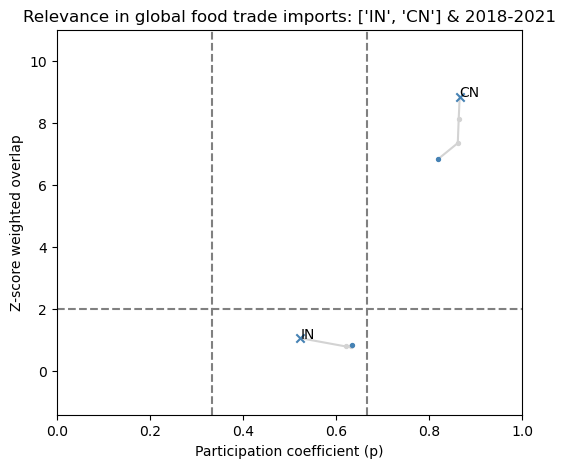

In [12]:
# need to do dynamic
def Country_map_static (dict_results, parameters, country_list, year_list= 'All', plt_flag=True, flag_annot ='Multi_hubs'):
    
    if (parameters['weight'] == True):
        w_f = '_w'
        flag_overlap = 'overl'
        title_overlap = 'weighted overlap'
    else:
        w_f = ''
        flag_overlap = 'deg'
        title_overlap = 'overlap (degree)'
    
    # Define start for All flags
    if country_list == 'All':
        country_list = list(dict_results[list(dict_results.keys())[0]].country)
        title_country = 'All countries'
    else: 
        title_country  = country_list
    
    if year_list == 'All':
        year_list = list(dict_results.keys())
        title_year  = 'All years'
    else: 
        title_year  = str(min(year_list))+'-'+str(max(year_list))

    if direction == 'in':
        dir_title = 'imports'
    else: 
        dir_title = 'exports'

    # Define figure characteristics 
    if plt_flag == True :
        maxY_plot = max([max(dict_results[y]['z_'+ direction+'_'+flag_overlap]) for y in list_years])
        minY_plot = min([min(dict_results[y]['z_'+ direction+'_'+flag_overlap]) for y in list_years])

        fig_phase, ax = plt.subplots(figsize = (6,5))
        ax.axvline(x=1/3, color='grey', linestyle= '--', zorder =1)
        ax.axvline(x=2/3, color='grey', linestyle= '--', zorder = 1)
        ax.axhline(y=2, color='grey', linestyle= '--', zorder = 1)
        ax.set_xlim (0,1)
        ax.set_xlim (0,1)
        #ax.set_ylim((minY_plot-1,maxY_plot+1))
        ax.set_ylim((minY_plot-1,11))
        #
        ax.set_ylabel('Z-score ' + title_overlap)
        ax.set_xlabel('Participation coefficient (p)')
        #ax.set_title ('Map with weighted overlap: '+ str(title_country) +' countries' +' & '+ str(title_year))
        ax.set_title ('Relevance in global food trade '+dir_title +': '+ str(title_country) +' & '+ str(title_year))

    # Iterate for countries:
    coords_dict = dict()
    for country in country_list:
        coords = pd.DataFrame()
        for y in year_list:
            to_add = dict_results[y].loc[(dict_results[y]['country']==country),('pc'+w_f+'_'+direction,'z_'+direction+'_'+flag_overlap)] 
            coords = pd.concat([coords,to_add])
        coords.index = year_list

        coords_dict[country] = coords
        if (plt_flag ==True):
            # Plot 
            if (len(year_list) == 1):
                ax.scatter(coords['pc'+w_f+'_'+direction].iloc[-1], coords['z_'+direction+'_'+flag_overlap].iloc[-1],zorder = 2,label= coords.index[-1],color = 'steelblue')
            else: 
                print(coords['pc'+w_f+'_'+direction].iloc[1:-2])
                ax.plot(coords['pc'+w_f+'_'+direction], coords['z_'+direction+'_'+flag_overlap],zorder = 2,label= coords.index,color ='lightgray')
                ax.scatter(coords['pc'+w_f+'_'+direction].iloc[1:-1], coords['z_'+direction+'_'+flag_overlap].iloc[1:-1],zorder = 2,s=8,label= coords.index,color ='lightgray')
                ax.scatter(coords['pc'+w_f+'_'+direction].iloc[0], coords['z_'+direction+'_'+flag_overlap].iloc[0],zorder = 2,label= coords.index[0],s=8,color = 'steelblue')# black
                ax.scatter(coords['pc'+w_f+'_'+direction].iloc[-1], coords['z_'+direction+'_'+flag_overlap].iloc[-1],zorder = 2,label= coords.index[-1],color = 'steelblue',marker='x')
            
            multi_hubs = coords.loc[(coords['pc_w_'+direction]>=2/3) & (coords['z_'+direction+'_overl']>=2),:]
            print(coords)
            if (flag_annot =='Multi_hubs') & (len(multi_hubs)>0):
                ax.annotate(country,(multi_hubs['pc'+w_f+'_'+direction].iloc[-1], multi_hubs['z_'+direction+'_'+flag_overlap].iloc[-1]),zorder = 2,label= multi_hubs.index[-1],color = 'black')
            elif (flag_annot =='All'):
                ax.annotate(country,(coords['pc'+w_f+'_'+direction].iloc[-1], coords['z_'+direction+'_'+flag_overlap].iloc[-1]),zorder = 2,label= coords.index[-1],color = 'black')

    fig_phase.savefig('../Plots/map_countries_'+dir_title+'_'+parameters['flag_unit']+'.pdf',format ='pdf',dpi=300)   
    plt.show()
    #print(country)
    return coords_dict


# Coords dict 
weight =True
group_class = 'Food_group'#'Food_group'
direction = 'in'
unit_flag = 'dollars' # tonnes

try:
    if direction == 'out':
        dict_results = dict_results_out
    else: 
        dict_results = dict_results_in
except:
    with open('../Data/'+direction+'_overlap_particip_'+unit_flag+'_'+group_class+'.pkl', 'rb') as f:
        print('Data_loaded')
        dict_results = pickle.load(f)
    
    list_years = dict_results.keys()


parameters = {'group_class':group_class, 'direction': direction,'weight':weight,'flag_unit':unit_flag}
coords_dict = Country_map_static(dict_results,parameters, country_list=['IN','CN'],year_list=[2018,2019,2020,2021],plt_flag = True, flag_annot='All')
# list(range(1986,2019))
coords =dict_results[2019]

# coords.loc[(coords['pc_w_'+direction]>=2/3) & (coords['z_'+direction+'_overl']>=2),:]

In [8]:
coords['pc_w_out']

0      0.884688
1      0.961507
2      0.944624
3      0.794436
4      0.912007
         ...   
214         NaN
215         NaN
216         NaN
217         NaN
218         NaN
Name: pc_w_out, Length: 219, dtype: float64

In [9]:
#coords.loc[(coords['pc_w_'+direction]>=2/3) & (coords['z_'+direction+'_overl']>=2),:]
